In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
import networkx as nx
%matplotlib inline

In [2]:
import itertools
import random
import statistics
from itertools import islice


In [3]:
from scipy.stats import power_divergence

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
from network import *

In [6]:
import math

In [7]:
from loaders import *

In [8]:
from IPython.core.display import Image, display

In [9]:

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [10]:
def plot_labels(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [11]:
def plot_dict(stat, xlbl, ylbl):
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

In [12]:
def plot_weighet_graph(graph, weights=None):
    if weights == None:
        weights = [1] * len(graph.nodes())
    
    nodesize = [weights[v] * 10000 for v in graph]
    try:
        pos=nx.nx_agraph.graphviz_layout(graph)
    except:
        pos=nx.spring_layout(graph,iterations=20)
    nx.draw(graph, node_size=nodesize, pos=pos, node_color="w")
    nx.draw_networkx_labels(graph, pos)
    

In [13]:
def get_time_seriece(weights_per_period, node):
    return [weights.get(node, 0.0) for weights in weights_per_period]

In [14]:
def get_weights_in_period(file ,start, end):
    coauthorNetwork = load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    (auth_subgraph, auth_weights, auth_sorted_nodes) = calc_pagerank(coauthorNetwork.gr)
    (cite_subgraph, cite_weights, cite_sorted_nodes) = calc_pagerank(coauthorNetwork.cgr)
    print("Top researchers", cite_sorted_nodes[:10])
    return ((auth_weights, auth_sorted_nodes), (cite_weights, cite_sorted_nodes) )

In [15]:
coauthorNetwork = CoauthorNetwork.load_with_loader("./data/out_test.txt", parse_dataset_file);


#run_analyse("./data/out_test.txt")
#run_analyse("./data/authors/Database.txt")
#run_analyse("./data/authors/Data Mining.txt")
#run_analyse("./data/authors/Theory.txt")
#run_analyse("./data/authors/Visualization.txt")


Uniq authors: 184962


 
Connected component distribution (log-scale)
pfinal: [ 1.66041534 -0.35053072]
covar: [[ 0.00211698 -0.00049636]
 [-0.00049636  0.00011761]]
Ampli = 45.75 +/-  0.50
Index = -0.35 +/-  0.05


/home/fckm/Work/Upwork/ahmed/src/citation_analisis/network.py:25: RuntimeWarning: divide by zero encountered in power
  powerlaw = lambda x, amp, index: amp * (x**index)


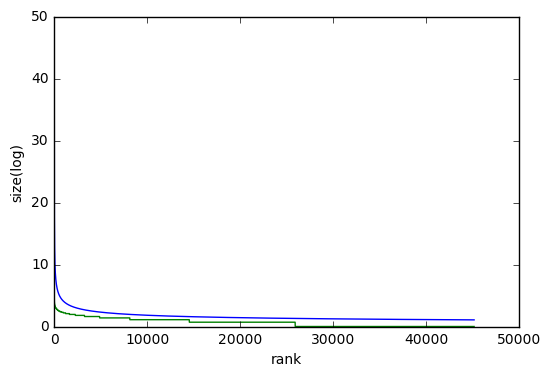

Power_divergenceResult(statistic=1246421768.3911831, pvalue=0.0)
Connected component count: 45147
----------
Authors count: 71460
Mean distance: 9.670112510495379
 
Distance distribution


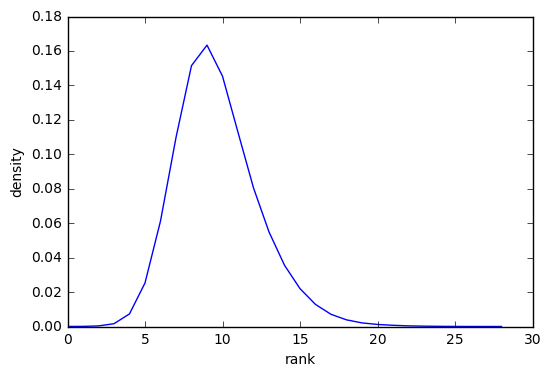

Top 10 authors by degree centrality measurement: [('Wei Wang', 0.001623308470591528), ('Gerhard Weikum', 0.0013854098154186317), ('Jie Yang', 0.0013014455841811388), ('Lei Zhang', 0.0011754992373248995), ('Philip S. Yu', 0.001105529044626989), ('Wei Li', 0.0010775409675478247), ('Jun Wang', 0.0010635469290082426), ('Ying Zhang', 0.0010635469290082426), ('Thomas A. DeFanti', 0.0010355588519290783), ('Rakesh Agrawal', 0.0010215648133894961)]
Top 10 authors by betweenness centrality measurement: [('Lei Liu', 0.10069340253179246), ('S. Y. Wang', 0.10032741376524165), ('Sascha Ossowski', 0.10016214256430268), ('J. R. Meyer', 0.10012594983273444), ('T. H. Myers', 0.10009446236475904), ('Federico Malucelli', 0.10008116765605833), ('Antonio Capone', 0.10003918436542446), ('Milind Tambe', 0.08230285883141399), ('Silvano Martello', 0.07866011370119803), ("Mauro Dell'Amico", 0.07845794038303734)]
Top 10 authors by closeness centrality measurement: [('Wei Wang', 0.16758716601117732), ('Philip S. Y

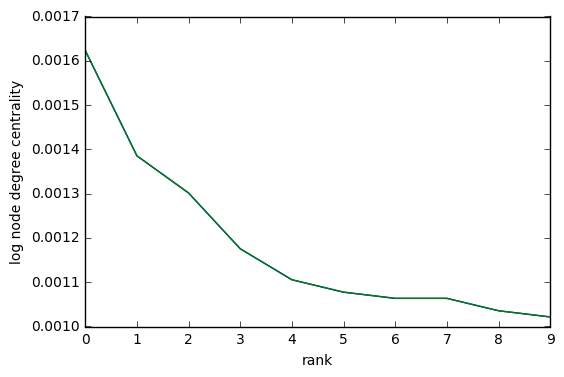

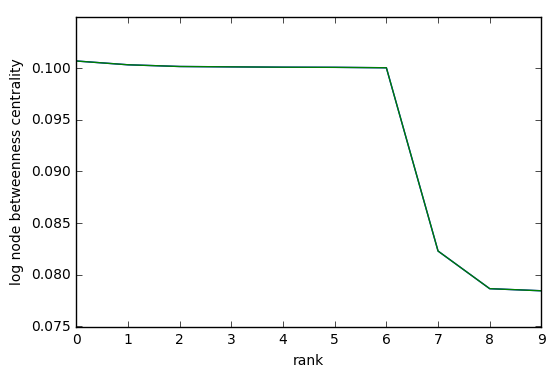

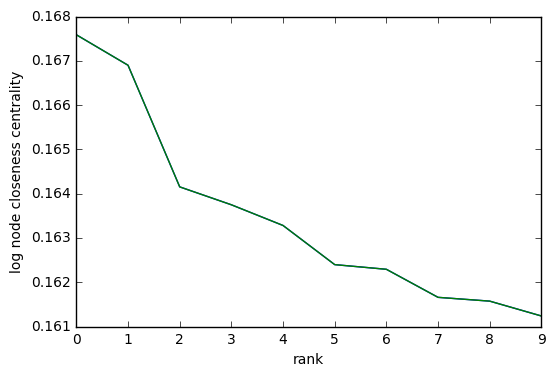

In [16]:

coauthorNetwork.gen_components()
coauthorNetwork.analize_component()
coauthorNetwork.print_info_component()


In [17]:
def calculate_cite_author_quantity_distribution(file, start, end):
    coauthor_network = CoauthorNetwork.load_with_loader(file, parse_dataset_file, lambda article: start <= article.year < end)
    dist = coauthor_network.calc_coauthor_cite_distribution()
    plot_pairs(dist[0], "number of coauthors", "article quantity")
    plot_pairs(dist[1], "number of citations", "article quantity")

# calculate_cite_author_quantity_distribution("./data/out_test.txt", 2000, 2001)

In [18]:
# Analyse time series
'''
file = "./data/out_test.txt"

coauthorNetwork = load_with_loader(file, parse_dataset_file)
nodes_count = len(coauthorNetwork.gr.nodes())

train_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]
test_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]

weights_per_period = []
weights_per_period.append(get_weights_in_period(file, 1990, 1995))
weights_per_period.append(get_weights_in_period(file, 1995, 2000))
weights_per_period.append(get_weights_in_period(file, 2000, 2005))
weights_per_period.append(get_weights_in_period(file, 2005, 2010))

weights_per_period_auth = [ w[0][0] for w in weights_per_period ]
weights_per_period_cite = [ w[1][0] for w in weights_per_period ]

x_train = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

# print("x_train", x_train[0:10])
# print("y_train", y_train[0:10])
x_test = [get_time_seriece(weights_per_period_auth, author) 
           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]
y_test = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]

lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)

for pair in zip(lm.predict(x_test)[0:10], y_test[0:10]):
    print(pair)
    
# print(lm.predict(x_test)[0:10])
# print(y_test[0:10])
'''


'\nfile = "./data/out_test.txt"\n\ncoauthorNetwork = load_with_loader(file, parse_dataset_file)\nnodes_count = len(coauthorNetwork.gr.nodes())\n\ntrain_authros = coauthorNetwork.gr.nodes()[:nodes_count // 2]\ntest_authors = coauthorNetwork.gr.nodes()[nodes_count // 2:]\n\nweights_per_period = []\nweights_per_period.append(get_weights_in_period(file, 1990, 1995))\nweights_per_period.append(get_weights_in_period(file, 1995, 2000))\nweights_per_period.append(get_weights_in_period(file, 2000, 2005))\nweights_per_period.append(get_weights_in_period(file, 2005, 2010))\n\nweights_per_period_auth = [ w[0][0] for w in weights_per_period ]\nweights_per_period_cite = [ w[1][0] for w in weights_per_period ]\n\nx_train = [get_time_seriece(weights_per_period_auth, author) \n           + get_time_seriece(weights_per_period_cite[0:-1], author) for author in test_authors]\ny_train = [weights_per_period_cite[-1].get(author, 0.0) for author in test_authors ]\n\n# print("x_train", x_train[0:10])\n# print(

In [19]:
stats = coauthorNetwork.top_authors_cite_coauth_stat()

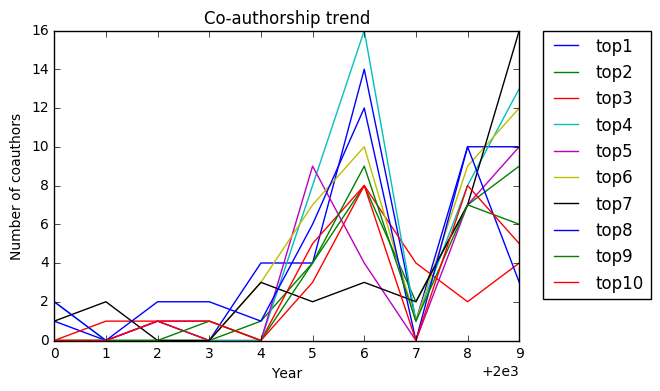

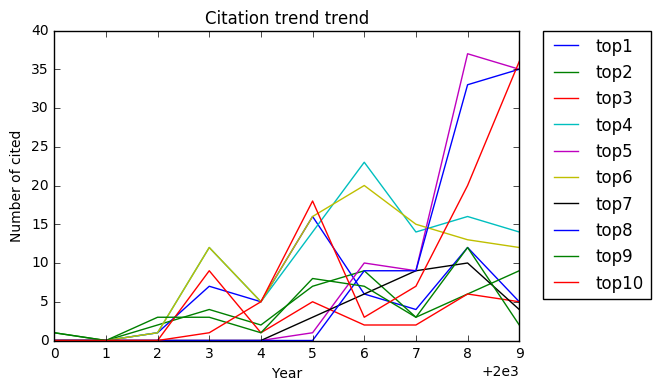

In [20]:
def render_stat(stat):
    for idx, author in enumerate(stat):
        rg = range(2000, 2010)
        author_line = [author.get(year, 0) for year in rg]
        plt.plot(list(rg), author_line, label="top" + str(idx + 1) ) 

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
plot_labels("Year", "Number of coauthors", "Co-authorship trend")
render_stat(stats[0])

plot_labels("Year", "Number of cited", "Citation trend trend")
render_stat(stats[1])


In [21]:
from graph_tools import *

In [22]:
print("co-authors:")
for x in calc_pagerank(coauthorNetwork.gr, 10)[2]:
    print(x[0])
print("citation:")
for x in calc_pagerank(coauthorNetwork.cgr, 10)[2]:
    print(x[0])

co-authors:
Wei Wang
Wei Li
Jie Yang
Chin-Chen Chang
Lei Zhang
Jun Wang
Li Li
Philip S. Yu
Qing Li
Jun Li
citation:
Donald E. Knuth
Teuvo Kohonen
Bertrand Meyer
Ian Foster
Ian H. Witten
Carl Kesselman
Simon Haykin
Eibe Frank
Gerard J. Holzmann
Hiroshi Ishii
